In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from scipy import stats

np.random.seed(seed=4711)

# Generate some data 

In [2]:
df = pd.DataFrame({"Year":list(range(1900,2000,10))*4,
                   "Season":["Spring"]*10+["Summer"]*10+["Fall"]*10+["Winter"]*10,
                   "Measurement":list(np.random.normal(0,1,10))+list(np.random.normal(2,1,30))})

# Plot the data 

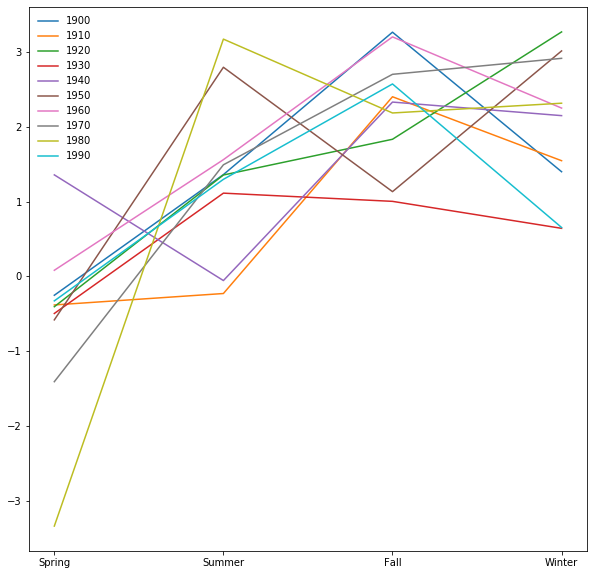

In [3]:
fig,ax = plt.subplots(1,1, figsize=(10,10))

for grp in df.groupby(["Year"]):
    plt.plot(grp[1]["Season"],grp[1]["Measurement"], label=grp[0])
    
ax.legend(loc='best', frameon=False)
plt.show()

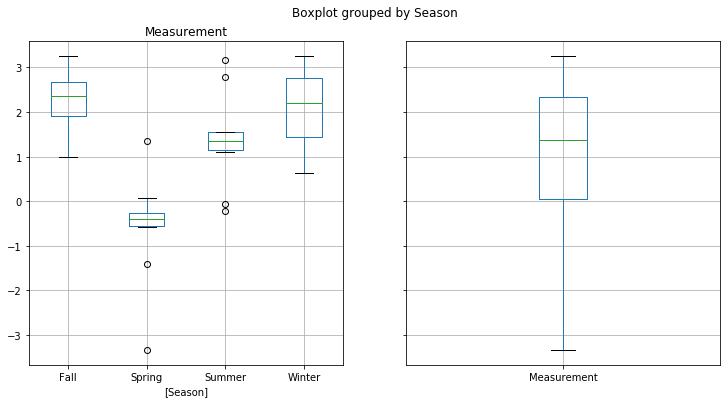

In [4]:
fig, ax = plt.subplots(1,2,sharey=True, figsize=(12,6))
df[["Season","Measurement"]].boxplot(by=["Season"],ax=ax[0]);
df[["Measurement"]].boxplot(ax=ax[1]);

# Example with statsmodels
from https://medium.com/@rrfd/f-tests-and-anovas-examples-with-the-iris-dataset-fe7caa3e21d0 

In [5]:
n = df["Measurement"].shape[0] # number of measurements
k = df["Season"].unique().shape[0] # 
dfn = k - 1 # degrees of freedom numerator
dfd = n - k # degrees of freedom denominator

### Perform the Shapiro-Wilk test for normality 

In [6]:
for key, frame in df.groupby("Season"):
    print("{}: {}".format(key, stats.shapiro(frame['Measurement'])))

Fall: (0.9339644908905029, 0.48799875378608704)
Spring: (0.8429773449897766, 0.04789799824357033)
Summer: (0.9065251350402832, 0.2579652667045593)
Winter: (0.9297192692756653, 0.44513657689094543)


### TODO QQ Plots 

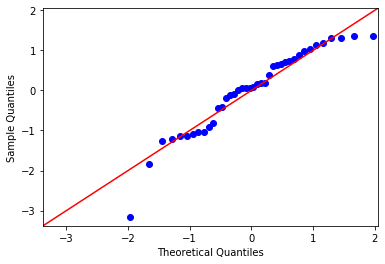

In [7]:
fig = sm.qqplot(df["Measurement"].values, fit=True, line='45')

### Test for homoscedasticity/ equal variance 

In [8]:
data = df[["Season","Measurement"]].groupby("Season")["Measurement"].apply(list)

#### Perform Bartlett’s test for equal variances

In [9]:
stats.bartlett(*data)

BartlettResult(statistic=1.754731493628056, pvalue=0.6248350560352256)

#### Perform Levene test for equal variances.

In [10]:
stats.levene(*data)

LeveneResult(statistic=0.1005830699396585, pvalue=0.9591582813016738)

### Perform a 1-way ANOVA.

In [11]:
stats.f_oneway(*data)

F_onewayResult(statistic=16.598013140255805, pvalue=6.167336089305777e-07)

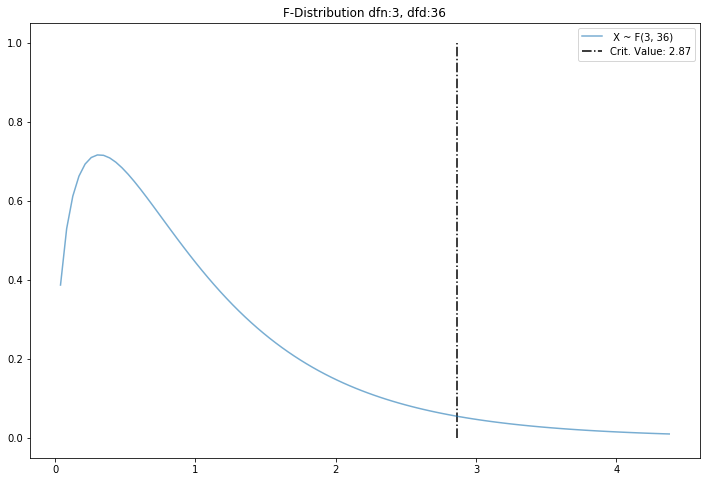

In [12]:
def plot_f_distrubiton(dfn, dfd):
    from scipy.stats import f, norm
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set figure 
    plt.figure(figsize=(12, 8))
    
    # Set degrees of freedom
    #dfn, dfd = 2, 147
    rejection_reg = f.ppf(q=.95, dfn=dfn, dfd=dfd)
    mean, var, skew, kurt = f.stats(dfn, dfd, moments='mvsk')
    
    x = np.linspace(f.ppf(0.01, dfn, dfd), 
                    f.ppf(0.99, dfn, dfd), 100)
    
    # Plot values
    plt.plot(x, f.pdf(x, dfn, dfd), alpha=0.6, 
             label=' X ~ F({}, {})'.format(dfn, dfd))
    plt.vlines(rejection_reg, 0.0, 1.0, 
               linestyles="dashdot", label="Crit. Value: {:.2f}".format(rejection_reg))
    plt.legend()
    plt.title('F-Distribution dfn:{}, dfd:{}'.format(dfn, dfd))

plot_f_distrubiton(dfn=dfn, dfd=dfd);

### statsmodels 

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

results = ols('Measurement ~ C(Season)', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Measurement   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     16.60
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           6.17e-07
Time:                        21:51:51   Log-Likelihood:                -54.571
No. Observations:                  40   AIC:                             117.1
Df Residuals:                      36   BIC:                             123.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2622    

In [14]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

              sum_sq    df          F        PR(>F)
C(Season)  49.598007   3.0  16.598013  6.167336e-07
Residual   35.858273  36.0        NaN           NaN
